In [ ]:
#default_exp main

In [ ]:
#export
import os
import pandas as pd
import numpy as np
import transformers

from fastai.text.all import *

from Hasoc import utils
from Hasoc import model

In [ ]:
#export
SEED = 42
utils.seed_everything(seed=SEED)

In [ ]:
#export 
MODEL_NAME = 'bert-base-uncased'
MAX_SEQ_LEN = 72
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
df = pd.read_csv(os.path.join('..', 'data', 'fold_df'))

In [ ]:
#hide
df.sample(2)

,tweet_id,text,task1,task2,ID,kfold_task1,kfold_task2
521,1126838046828191744,@ZaneRasp Stop you’re making me attracted to you,NOT,NONE,hasoc_2020_en_3572,2,0
737,1126818526558347264,"RT @sohmer: @realDonaldTrump The Importer pays the tariffs, you fucking moron. You’ve levied a sales tax on yours own citizens.",HOF,HATE,hasoc_2020_en_4070,2,0


In [ ]:
#hide
df['task1'].value_counts()

HOF    501
NOT    499
Name: task1, dtype: int64

In [ ]:
#hide
df['task2'].value_counts()

NONE    499
PRFN    391
OFFN     76
HATE     34
Name: task2, dtype: int64

In [ ]:
#export
df.tweet_id = df.tweet_id.astype('int').astype('str')

In [ ]:
#export
bert_tokenizer = transformers.BertTokenizer.from_pretrained(
            pretrained_model_name_or_path=MODEL_NAME,
            do_lower_case=True,
            )

In [ ]:
bert_vocab = bert_tokenizer.get_vocab()
bert2fastai_vocab = [k for k, v in sorted(bert_vocab.items(), key=lambda item: item[1])]

In [ ]:
#export 
pad = partial(pad_input_chunk, pad_first=False, pad_idx=bert_tokenizer.pad_token_id, seq_len=MAX_SEQ_LEN)

In [ ]:
#export
custom_tokenizer = Tokenizer.from_df(text_cols='text', tok=utils.HFTokenizer(tokenizer=bert_tokenizer), rules=[])

In [ ]:
#export
tfms = [attrgetter('text'), custom_tokenizer, Numericalize(vocab=bert2fastai_vocab), utils.Add_Special_Cls(tokenizer=bert_tokenizer)]

In [ ]:
fold = 0
splits = IndexSplitter(list(df.query(f'kfold_task1 == {fold}').index))(df)

In [ ]:
#hide
splits

((#785) [0,1,2,4,5,6,8,9,10,13...], (#215) [3,7,11,12,16,32,33,38,41,45...])

In [ ]:
#export
dsets = Datasets(df, tfms=[tfms, [attrgetter('task1'), Categorize()]], splits=splits, dl_type=SortedDL)

In [ ]:
#export
dls_clas = dsets.dataloaders(bs=56, val_bs=144, before_batch=[pad], seq_len=MAX_SEQ_LEN)

In [ ]:
#export
dls_clas.show_batch(max_n=2)

,text,category
0,[CLS] rt @ na ##lu _ for _ you : after na ##lu one of my favourite [UNK] - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - … [SEP],NOT
1,"[CLS] rt @ 780 ##6 ##13 : seo ##k ##jin ##s mom : how can u not see me when im cheering like "" ah ##hh ##h ! ! ! ya ##hh ##h ! ! ! ! ! ! seo ##k ##jin - ah ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ya ##hh ##hh ##h ! ! ! ! ! ! ! ! ! ! "" … [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",NOT


In [ ]:
#export
modeller = model.HasocModel(out_feat=dsets.c)

In [ ]:
#export
learn = Learner(dls_clas, modeller.to(device), metrics=[accuracy, F1Score(average='macro')], 
                drop_mult=0.3, device=device, loss_func=CrossEntropyLossFlat())

SuggestedLRs(lr_min=5.754399462603033e-05, lr_steep=0.0003311311302240938)

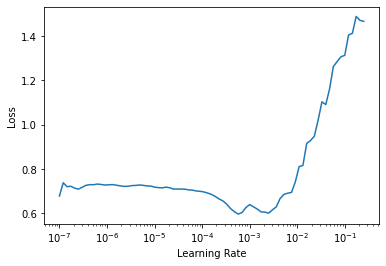

In [ ]:
#export
learn.lr_find()

In [ ]:
#export
lr = 2e-4

# learn.fit_one_cycle(7, lr, moms=(0.8,0.7,0.8), wd=0.1)
learn.fit_one_cycle(7, lr)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.702877,0.589136,0.660465,0.635754,00:07
1,0.501483,0.375413,0.920930,0.920683,00:07
2,0.372280,0.299125,0.902326,0.901910,00:07
3,0.284414,0.290597,0.865116,0.865070,00:08
4,0.221690,0.327099,0.920930,0.920821,00:08
5,0.177184,0.305131,0.920930,0.920759,00:07
6,0.138274,0.295286,0.920930,0.920759,00:07


In [ ]:
#export
learn.export(os.path.join('models', 'task1.pkl'))
# learn.save((os.path.join('task1')))

## Task2

In [ ]:
#export
dsets = Datasets(df, tfms=[tfms, [attrgetter('task2'), Categorize()]], splits=splits, dl_type=SortedDL)

In [ ]:
#export
dls_clas = dsets.dataloaders(bs=56, val_bs=144, before_batch=[pad], seq_len=MAX_SEQ_LEN)

In [ ]:
#export
dls_clas.show_batch(max_n=2)

,text,category
0,[CLS] rt @ na ##lu _ for _ you : after na ##lu one of my favourite [UNK] - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - … [SEP],NONE
1,"[CLS] rt @ 780 ##6 ##13 : seo ##k ##jin ##s mom : how can u not see me when im cheering like "" ah ##hh ##h ! ! ! ya ##hh ##h ! ! ! ! ! ! seo ##k ##jin - ah ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ya ##hh ##hh ##h ! ! ! ! ! ! ! ! ! ! "" … [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]",NONE


In [ ]:
#export
modeller = model.HasocModel(out_feat=dsets.c)

No weighting

In [ ]:
#export
learn = Learner(dls_clas, modeller.to(device), metrics=[accuracy, F1Score(average='macro')], drop_mult=0.3, device=device, loss_func=CrossEntropyLossFlat())

SuggestedLRs(lr_min=0.00020892962347716094, lr_steep=3.630780702224001e-05)

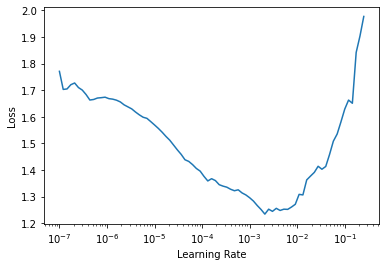

In [ ]:
#export
learn.lr_find()

In [ ]:
#export
lr = 4e-4

# learn.fit_one_cycle(7, lr, moms=(0.8,0.7,0.8), wd=0.1)
learn.fit_one_cycle(7, lr)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.166778,0.850898,0.734884,0.381913,00:08
1,0.910614,0.638937,0.804651,0.420619,00:08
2,0.800811,0.599820,0.837209,0.438761,00:07
3,0.698138,0.651485,0.800000,0.467121,00:07
4,0.649339,0.605674,0.823256,0.497222,00:07
5,0.590672,0.560916,0.855814,0.550468,00:07
6,0.527716,0.557759,0.855814,0.550468,00:08


In [ ]:
#export
learn.export(os.path.join('models', 'task2.pkl'))

## interp

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

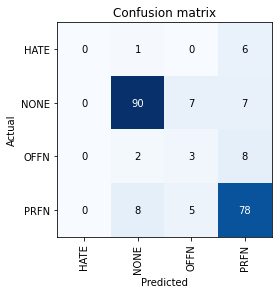

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
learn.predict('What the fuck are you talking. go to hell')

('PRFN', tensor(3), tensor([1.9603e-03, 8.5831e-04, 8.3661e-03, 9.8882e-01]))

In [ ]:
learn.predict("I will chop off your head and kill you")

('HATE', tensor(0), tensor([0.6577, 0.1883, 0.0711, 0.0829]))